In [5]:
!pip install easyesn

  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=fda6223bb772cb81883a1abacec474d4be72874a376c36db46b858e6930a41fe
  Stored in directory: c:\users\adamg\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
from scipy.stats import cauchy
from easyesn import PredictionESN

Using Numpy backend.


In [57]:
w_0 = 462 # [GHz] Centre frequency

# THESE DIRECTLY RELATE TO THE SCALING FACTORS
sigma_short = 0.33 # [GHz] Timescale of minute (Translates to about 0.8nm deviation)
sigma_long = 0.66 # [GHz] Timescale of hours

laser_linewidth = 10000 # [Hz] maximum
laser_precision = 50*10**6 # [Hz] not sure what this means
spd_efficiency = 0.9 # worst case
spd_jitter = 100*10**-12 # [s]

tau_r = 900*10**-12 # [s] radiative lifetime
h_bar = 1.054571817*10**-34 # [J*s]
linewidth = 1/tau_r
print(linewidth)

1111111111.1111112


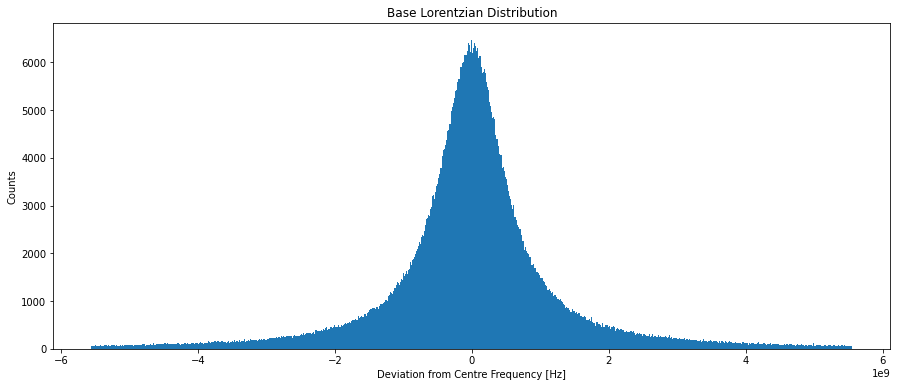

In [58]:
lor = cauchy.rvs(loc=0,scale=linewidth/2,size=1000000)

plt.title("Base Lorentzian Distribution")
plt.xlabel("Deviation from Centre Frequency [Hz]")
plt.ylabel("Counts")
plt.hist(lor,bins=1000,range=(-5*linewidth,5*linewidth));
# Linewidth should be in about the kHz range
# Convert to Frequency from energy

In [9]:
class Spectrum_Simulator:
        def __init__(self, centre=0, FWHM=1):
            self.centre = centre
            self.FWHM = FWHM
            self.num_noises = 0
            self.windows = []
            self.stds = []
            self.corrections = []
            self.random = []
            self.smooth = []
            self.smoother = []
            self.smoothest = []
            self.wandering = []
            
        def add_noise(self, window, std):
            self.num_noises += 1
            self.windows.append(window)
            self.stds.append(std)
            self.corrections.append(self.compute_correction(window))
            self.random.append(np.zeros(window))
            self.smooth.append(np.zeros(window))
            self.smoother.append(np.zeros(window))
            self.smoothest.append(np.zeros(window))
                
        def compute_correction(self,window):
            num_steps = 10000*window
            random = np.zeros(window)
            smooth = np.zeros(window)
            smoother = np.zeros(window)
            smoothest = np.zeros(window)
            wandering = np.zeros(num_steps)
            for i in range(num_steps):
                random = np.roll(random,1)
                smooth = np.roll(smooth,1)
                smoother = np.roll(smoother,1)
                smoothest = np.roll(smoothest,1)
                random[0] = np.random.normal(0,1,1)
                smooth[0] = np.sum(random)/window
                smoother[0] = np.sum(smooth)/window
                smoothest[0] = np.sum(smoother)/window
                wandering[i] = np.sum(smoothest)/window
            return np.std(wandering)
        
        def step(self):
            sum = 0
            for noise in range(self.num_noises):
                self.random[noise] = np.roll(self.random[noise],1)
                self.smooth[noise] = np.roll(self.smooth[noise],1)
                self.smoother[noise] = np.roll(self.smoother[noise],1)
                self.smoothest[noise] = np.roll(self.smoothest[noise],1)
                
                self.random[noise][0] = np.random.normal(0,1,1)
                self.smooth[noise][0] = np.sum(self.random[noise])/self.windows[noise]
                self.smoother[noise][0] = np.sum(self.smooth[noise])/self.windows[noise]
                self.smoothest[noise][0] = np.sum(self.smoother[noise])/self.windows[noise]
                
                sum += np.sum(self.smoothest[noise])/self.windows[noise]
                
            self.wandering.append(sum*self.stds[noise]/self.corrections[noise])
            
        def measure_counts(target_freq, boundaries, time):
            
            return
            

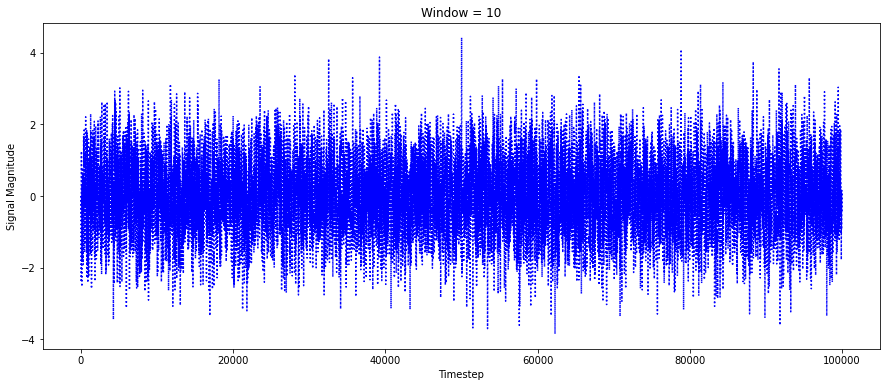

In [52]:
window = 10
std = 1
num_steps = 100000
plot = True

sim = Spectrum_Simulator()
sim.add_noise(window,std)
for i in range(num_steps):
    sim.step()
    
if plot == True:
    times = np.arange(num_steps)
    plt.rcParams['figure.figsize'] = [15, 6]
    plt.title("Window = 10")
    plt.xlabel("Timestep")
    plt.ylabel("Signal Magnitude")
    plt.plot(times,np.array(sim.wandering),linestyle=':',color='b')

In [53]:
x = np.array(sim.wandering[0::1])
y = np.array(sim.wandering[5::1])
len = y.size
train_len = int(0.99*len)
test_len = len-train_len
x_train = x[0:train_len]
y_train = y[0:train_len]
x_test = x[0:test_len]
y_test = y[0:test_len]

In [54]:
esn = PredictionESN(n_input=1, n_output=1, n_reservoir=50, leakingRate=0.2,
                    regressionParameters=[1e-2], solver="lsqr", feedback=False)
esn.fit(x_train, y_train, transientTime="Auto", verbose=1)

100% (98876 of 98876) |##################| Elapsed Time: 0:00:02 Time:  0:00:02


0.2060686493312172

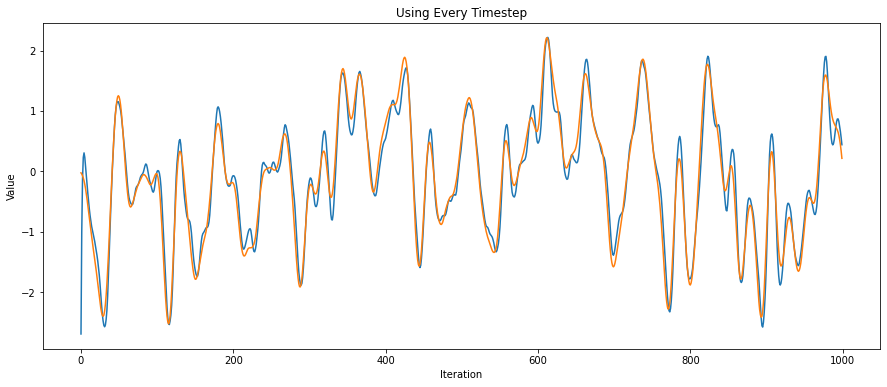

In [56]:
one_step_prediction = esn.predict(x_test)
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("Using Every Timestep")
plt.plot(one_step_prediction.T[0,:])
plt.plot(y_test)
plt.show()

In [46]:
print(x_test[0:10])

[-2.08941096e-04 -1.08955599e-03 -3.17943576e-03 -7.74175316e-03
 -1.73415186e-02 -3.48338978e-02 -6.29468629e-02 -1.03920328e-01
 -1.60331351e-01 -2.34194117e-01]
